# Clasificador de Señales de Tránsito con ResNet50

Este proyecto implementa un clasificador de señales de tránsito utilizando Transfer Learning con la arquitectura ResNet50 pre-entrenada en ImageNet.

## Características del Dataset

- **Total de imágenes**: 39,209 en entrenamiento
- **Número de clases**: 43 tipos de señales de tránsito
- **Organización**: Estructura de carpetas por clase

[Link del Dataset](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)

## Tabla de Contenidos

1. Configuración Inicial
2. Preparación de Datos
3. Construcción del Modelo
4. Entrenamiento
5. Evaluación y Predicción


## 1. Configuración Inicial

### Imports y Dependencias

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import os

**Librerías utilizadas:**
- **TensorFlow/Keras**: Framework principal para deep learning
- **ResNet50**: Modelo pre-entrenado de 50 capas para transfer learning
- **ImageDataGenerator**: Para carga y procesamiento de imágenes
- **NumPy**: Operaciones numéricas
- **Matplotlib**: Visualización de resultados

### Parámetros de Configuración

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CARPETA_ENTRENAMIENTO = "dataset/Train"
CARPETA_PRUEBAS = "dataset/Test"
CARPETA_META = "dataset/Meta"

**Configuración del proyecto:**
- **IMAGE_SIZE**: Tamaño estándar requerido por ResNet50 (224x224 píxeles)
- **BATCH_SIZE**: 32 imágenes procesadas simultáneamente
- **Rutas del dataset**: Organización en carpetas Train/Test/Meta

## 2. Preparación de Datos

### Generador de Datos de Entrenamiento

In [3]:
train_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    CARPETA_ENTRENAMIENTO,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

Found 32295 images belonging to 43 classes.


**Características:**
- **Normalización**: Escala los píxeles de [0, 255] a [0, 1]
- **flow_from_directory**: Carga automática desde estructura de carpetas
- **class_mode="categorical"**: Para clasificación multi-clase con one-hot encoding
- **shuffle=True**: Mezcla aleatoria de datos en cada época

## 3. Construcción del Modelo

### Arquitectura con Transfer Learning

In [4]:
# Modelo base pre-entrenado
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
preds = Dense(len(train_generator.class_indices), activation="softmax")(x)

# Modelo completo
model = Model(inputs=base_model.input, outputs=preds)

**Componentes del modelo:**

1. **ResNet50 Base**:
   - Pre-entrenado en ImageNet (1.4M imágenes, 1000 clases)
   - `include_top=False`: Excluye las capas de clasificación originales
   - Extrae características visuales de alto nivel

2. **GlobalAveragePooling2D**:
   - Reduce dimensionalidad espacial
   - Convierte mapas de características en vector 1D
   - Evita overfitting comparado con capas densas

3. **Capa Dense Final**:
   - 43 neuronas (una por cada clase de señal)
   - Activación softmax para probabilidades
   - Clasificación multi-clase

### Compilación del Modelo

In [5]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

**Parámetros:**
- **Optimizer**: Adam (adaptive learning rate)
- **Loss**: Categorical crossentropy para multi-clase
- **Metrics**: Exactitud de clasificación

## 4. Entrenamiento

### Configuración de Checkpoint

In [ ]:
checkpoint = ModelCheckpoint(
    "mejor_modelo.keras",
    save_best_only=True,
    monitor="loss",
    mode="min",
    verbose=1
)

**Función del checkpoint:**
- Guarda automáticamente el mejor modelo durante entrenamiento
- Monitorea la pérdida (loss) y guarda cuando mejora
- Formato `.keras`

### Entrenamiento Inicial

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    callbacks=[checkpoint]
)

model.save("modelo_final.keras")

class_names = list(train_generator.class_indices.keys())
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

**Proceso:**
- Entrena por 5 épocas completas
- Guarda progreso con el callback
- Genera archivo final `modelo_final.keras`
- Extrae nombres de las 43 clases
- Guarda class_names en archivo JSON para cargar posteriormente

### Entrenamiento Continuado (Opcional)

In [ ]:
# Cargar modelo guardado
model = tf.keras.models.load_model("mejor_modelo.keras")

# Continuar entrenamiento
history = model.fit(
    train_generator,
    epochs=5,
    initial_epoch=5,  # en este caso continia desde el 4
    callbacks=[checkpoint]
)

model.save("modelo_final.keras")

class_names = list(train_generator.class_indices.keys())
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

**Resultado del entrenamiento:**
```
Epoch 5/5
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4183s 3s/step
- accuracy: 0.9955
- loss: 0.0161

## 5. Evaluación y Predicción

### Sistema de Prueba Automático

#### 5.1 Selección Aleatoria de Imagen

In [6]:
def escoger_imagen_aleatoria(carpeta_pruebas):
    extensiones = (".jpg", ".jpeg", ".png")
    imagenes = [f for f in os.listdir(carpeta_pruebas)
                if f.lower().endswith(extensiones)]

    if not imagenes:
        raise ValueError("No hay imágenes en la carpeta de pruebas.")

    imagen_aleatoria = random.choice(imagenes)
    ruta_imagen = os.path.join(carpeta_pruebas, imagen_aleatoria)

    return ruta_imagen

**Funcionalidad:**
- Busca todas las imágenes en carpeta Test
- Soporta formatos JPG, JPEG, PNG
- Selecciona una imagen al azar para prueba

#### 5.2 Predicción de Imagen

In [15]:
def predecir(model, ruta_imagen, class_names):

    img_bytes = tf.io.read_file(ruta_imagen)
    img = tf.image.decode_image(img_bytes, channels=3)

    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0

    img = tf.expand_dims(img, axis=0)

    pred = model.predict(img, verbose=0)
    clase_idx = tf.argmax(pred[0]).numpy()
    clase_predicha = class_names[clase_idx]

    return clase_predicha


**Pasos del proceso:**
1. **Carga**: Redimensiona a 224x224
2. **Normalización**: Escala píxeles [0,1]
3. **Batch dimension**: Añade dimensión para el modelo
4. **Predicción**: Obtiene probabilidades de todas las clases
5. **Selección**: Escoge la clase con mayor probabilidad

#### 5.3 Visualización de Resultados

In [16]:
def obtener_imagen_meta(carpeta_meta, clase_predicha):
    posibles_ext = [".jpg", ".jpeg", ".png"]

    for ext in posibles_ext:
        ruta = os.path.join(carpeta_meta, clase_predicha + ext)
        if os.path.exists(ruta):
            return ruta

    return None

def mostrar_comparacion(ruta_prueba, ruta_meta, clase_predicha):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Imagen de prueba
    img1 = tf.keras.utils.load_img(ruta_prueba)
    ax[0].imshow(img1)
    ax[0].set_title(f"Imagen de Prueba\n{os.path.basename(ruta_prueba)}")
    ax[0].axis("off")

    # Imagen meta (referencia)
    if ruta_meta:
        img2 = tf.keras.utils.load_img(ruta_meta)
        ax[1].imshow(img2)
        ax[1].set_title(f"Imagen META\nClase: {clase_predicha}")
    else:
        ax[1].text(0.5, 0.5, "No existe imagen-meta",
                   ha="center", va="center", fontsize=12)
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

**Sistema de comparación:**
- Busca imagen de referencia en carpeta Meta
- Muestra lado a lado: imagen de prueba vs. señal de referencia
- Permite verificación visual de la predicción

#### 5.4 Función Principal de Prueba

In [17]:
def prueba_completa(model, carpeta_pruebas, carpeta_meta, class_names):
    # 1. Elegir imagen aleatoria
    imagen_prueba = escoger_imagen_aleatoria(carpeta_pruebas)

    # 2. Obtener predicción
    clase = predecir(model, imagen_prueba, class_names)

    # 3. Buscar imagen meta
    ruta_meta = obtener_imagen_meta(carpeta_meta, clase)

    # 4. Mostrar resultado
    mostrar_comparacion(imagen_prueba, ruta_meta, clase)

### Ejecución de Pruebas

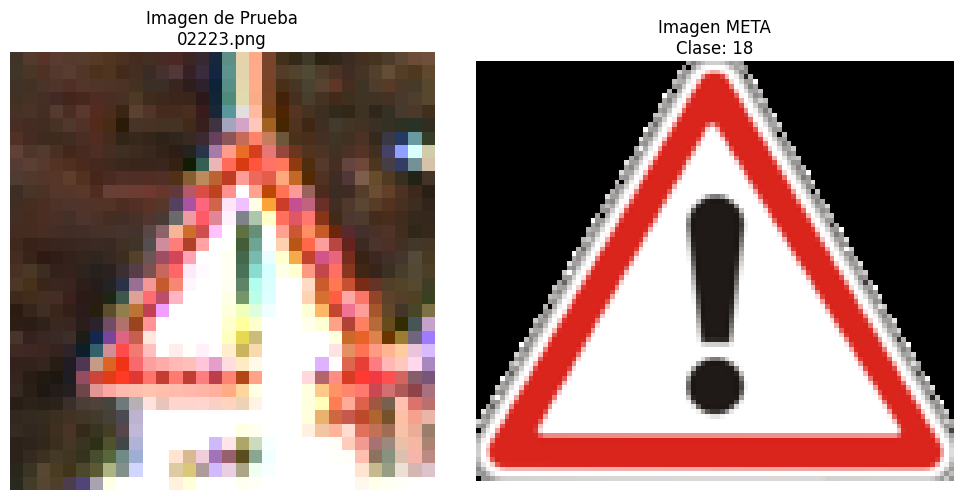

In [31]:
# Cargar el modelo
model = tf.keras.models.load_model("modelo_final.keras")

# Cargar los nombres de las clases
with open("class_names.json", "r") as f:
    class_names = json.load(f)

prueba_completa(model, CARPETA_PRUEBAS, CARPETA_META, class_names)